In [268]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from pprint import pprint

sns.set_style('darkgrid')

In [269]:
def get_dataset_from_config_txt(config_txt):
    return config_txt.iloc[8][0]

def get_num_words_from_tsv(record_tsv):
    return int(record_tsv.iloc[-1][0].split(" ")[0])

def get_num_sentences_from_tsv(record_tsv):
    return int(record_tsv.iloc[-1][0].split(" ")[3])

def get_best_F1_from_tsv(record_tsv):
    train_max = max([float(a) for a in record_tsv['T_F1']])
    val_max = [float(a) for a in record_tsv['V_F1']][-6]
    # val_max = max([float(a) for a in record_tsv['V_F1']])
    assert all(np.isnan(float(a)) for a in record_tsv['V_F1'][-3:])
    
    return {"train": train_max, "val": val_max}
    # return {"train": max(train_curve), "val": max(val_curve)} # Might be worth checking how long they train for too?

def get_acquisition_from_root(root):
    
    with open(os.path.join(root, "config.txt")) as f:
        config_txt = f.read()
    
    ac = config_txt.split("Acquisition strategy: ")[1].split(" ")[0]
    
    if "BEFORE" in config_txt.split("Acquisition strategy: ")[1].split(" "):
        print("woah")
        return False
    else:
        return ac
    

def verify_root(verification_dict):
    for k, v in verification_dict.items():
        for hint in v:
            if hint in k:
                break
        else:
            return False
    return True

def diff_size_mean(method, arrays, show = False):
    
    lens = [len(a) for a in arrays]
    max_len = max(lens)
    if show: print(lens)
    element_or_zero = lambda x, i: (x[i],1) if len(x) > i else False
    out_array = np.zeros(max_len)

    for i in range(max_len):
        
        e_and_c = [element_or_zero(arr, i) for arr in arrays]
        e_and_c = [a for a in e_and_c if a]
                   
        if method == "mean":
            next_element = sum([a[0] for a in e_and_c])/sum([a[1] for a in e_and_c])
        elif method == "max":
            next_element = max([a[0] for a in e_and_c])
        elif method == "min":
            next_element = min([a[0] for a in e_and_c])
        
        out_array[i] = next_element

    return out_array

In [273]:
acquisitions = ['rand', 'lc'] #, 'maxent']#, 'mnlp'] 
dataset_hint = "OntoNotes-5.0/NER"
window_hint = ['5', '-1']

all_results = {}
roots = []
all_roots = []
#all_roots.extend(glob(f"*/*-202*:*"))
all_roots.extend(glob(f"*--202*:*"))
# all_roots.extend(glob(f"BASELINE_24_11_20/record-*-202*"))

for root in all_roots:
    config_txt = pd.read_csv(os.path.join(root, "config.txt"), sep = "\t")
    _dataset = config_txt.iloc[12][0]
    _window_size = config_txt.iloc[5][0]
    _acquisition = config_txt.iloc[6][0]
    _beta = config_txt.iloc[9][0]
    _T = config_txt.iloc[11][0]
    _norm = config_txt.iloc[10][0]
    _roundsize = config_txt.iloc[8][0] 
    _initprop = config_txt.iloc[7][0]
    
    if dataset_hint not in _dataset:
        continue
    
    # verification_dict = {
    #     _dataset: dataset_hint,
    #     _window_size: window_hint,
    #     _acquisition: acquisitions
    # }
    # if not verify_root(verification_dict):
    #     continue
    
    name = f"{_roundsize}, {_acquisition}, {_window_size}, {_beta}, {_T}, {_norm}, {_initprop}"
    if not all_results.get(name):
        all_results[name] = {
            "roots": [root],
            "num_sentences": [],
            "num_words": [],
            "F1": {"train": [], "val": []},
        }
    else:
        all_results[name]["roots"].append(root)


len(list(all_results.keys()))

17

In [274]:
for name, results in all_results.items():
    
    roots = results["roots"]

    for root in roots:

        records = sorted(glob(os.path.join(root, "round-*")), key = lambda x: int(x.split("-")[-1]))

        all_num_words = []
        all_num_sentences = []
        all_F1s = []

        acquisition_function = get_acquisition_from_root(root)
        if not acquisition_function:
            continue

        for record in records:

            record_tsv = pd.read_csv(os.path.join(record, "record.tsv"), sep = "\t")

            num_words = get_num_words_from_tsv(record_tsv)
            num_sentences = get_num_sentences_from_tsv(record_tsv)
            F1 = get_best_F1_from_tsv(record_tsv)

            if num_words in all_num_words:
                break

            all_num_words.append(num_words)
            all_num_sentences.append(num_sentences)
            all_F1s.append(F1)

        results["num_sentences"].append(np.array(all_num_sentences))
        results["num_words"].append(np.array(all_num_words))
        results["F1"]["val"].append(
            np.array([a['val'] for a in all_F1s])
        )
        results["F1"]["train"].append(
            np.array([a['train'] for a in all_F1s])
        )

roundsize 10000, acquisition rand, window ['5'], beta -0.01, temperature 1.0, alpha 1.0, initprop 0.01
[141, 136]
roundsize 10000, acquisition rand, window ['5'], beta 0.1, temperature 1.0, alpha 1.0, initprop 0.01
[140, 140]
roundsize 10000, acquisition rand, window ['5'], beta 0.0, temperature 1.0, alpha 1.0, initprop 0.01
[146, 143, 138]
roundsize 10000, acquisition lc, window ['-1'], beta 0.0, temperature 1.0, alpha 0.0, initprop 0.01
[1, 146, 1]
roundsize 20000, acquisition lc, window ['5'], beta 0.0, temperature 1.0, alpha 1.0, initprop 0.01
[47, 0, 50, 1]
roundsize 10000, acquisition lc, window ['-1'], beta 0.0, temperature 1.0, alpha 0.7, initprop 0.01
[73, 1, 1, 0]
roundsize 10000, acquisition lc, window ['5'], beta 0.0, temperature 1.0, alpha 1.0, initprop 0.01
[61, 71]
roundsize 10000, acquisition lc, window ['-1'], beta 0.0, temperature 1.0, alpha 1.0, initprop 0.01
[1, 1]
roundsize 10000, acquisition lc, window ['5'], beta 0.1, temperature 2.5, alpha 1.0, initprop 0.01
[13

(0, 1800000.0)

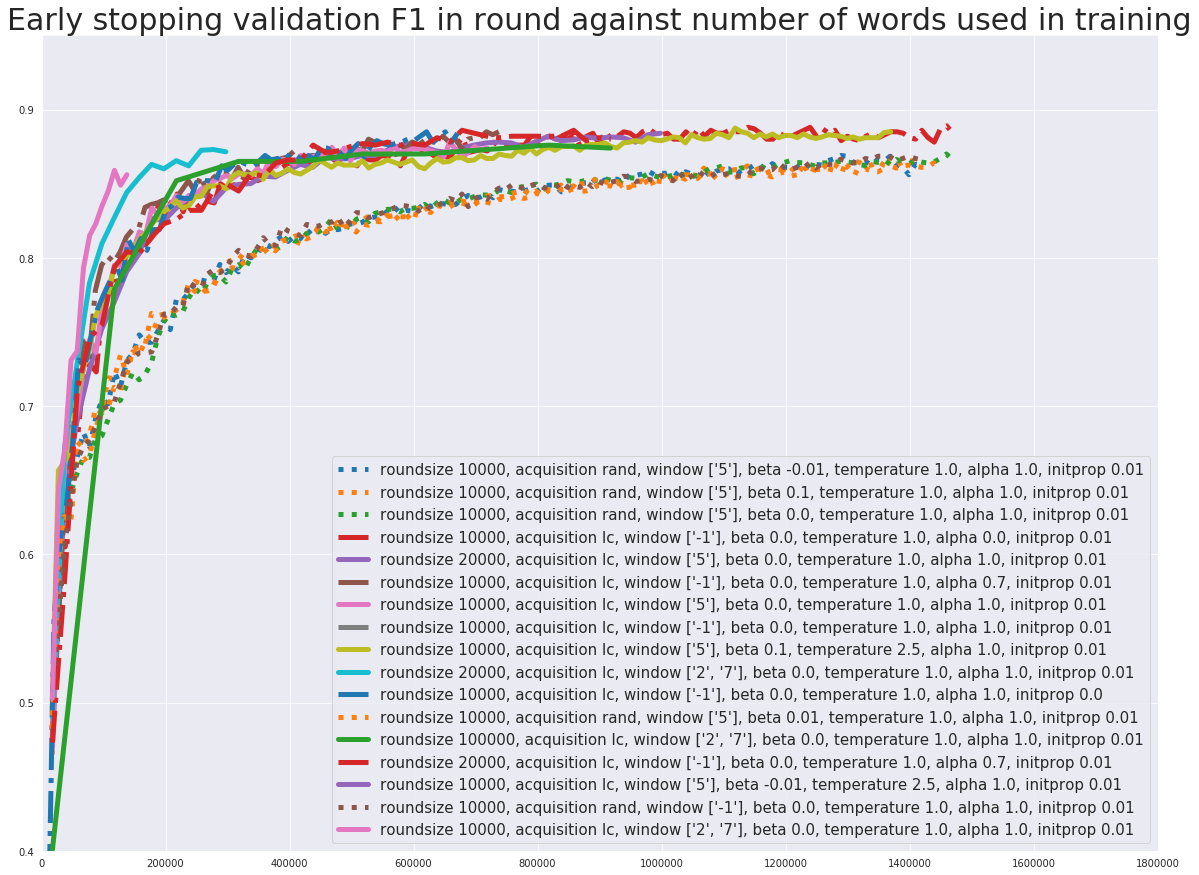

In [275]:
fig, axs = plt.subplots(1, figsize = (20, 15))
axs = [None, axs]

for ac in all_results.keys():
    
    #if ac == "OntoNotes-5.0/NER, roundsize 80000, acquisition lc, window ['5'], beta 0.0, temperature 1.0, alpha 1.0" or ("window ['-1']" in ac or "window -1" in ac):
    #    pass
    #else:
    #    continue
    
    if "window ['-1']" and 'acquisition rand' in ac:
        ls = 'dotted'
        # ls = 'None'
        alpha = 0
    elif "window ['-1']" in ac and 'acquisition lc' in ac:
        ls = 'dashdot'
        # ls = 'None'
        alpha = 0
    elif "window ['5']" in ac and 'acquisition rand' in ac:
        ls = 'dashed'
        alpha = 0
    elif "window ['5']" in ac and 'acquisition lc' in ac:
        ls = 'solid'
        alpha = 0
    elif "window ['2', '7']" in ac:
        ls = 'solid'
        alpha = 0
    
    print(ac)
    
    # axs[0].plot(
    #     num_sentences,
    #     diff_size_mean("mean", all_results[ac]["F1"]["val"]),
    #     label = ac, linewidth = 3, linestyle=ls
    # )
    # axs[0].fill_between(
    #     num_sentences,
    #     diff_size_mean("max", all_results[ac]["F1"]["val"]),
    #     diff_size_mean("min", all_results[ac]["F1"]["val"]),
    #     alpha=0.3
    # )
    num_words = diff_size_mean("mean", all_results[ac]["num_words"], False)
    num_sentences = diff_size_mean("mean", all_results[ac]["num_sentences"], True)

    axs[1].plot(
        num_words,
        diff_size_mean("mean", all_results[ac]["F1"]["val"]),
        label = ac, linewidth = 5, linestyle=ls
    )
    axs[1].fill_between(
        num_words,
        diff_size_mean("max", all_results[ac]["F1"]["val"]),
        diff_size_mean("min", all_results[ac]["F1"]["val"]),
        alpha=alpha
    )
    del alpha
    del ls
    

axs[1].set_title("Early stopping validation F1 in round against number of words used in training", fontsize = 30)

# axs[0].legend()
axs[1].legend(fontsize = 15)#bbox_to_anchor=(0.7, 0), fontsize=25)
axs[1].set_ylim(0.4, 0.95)
axs[1].set_xlim(0, 1.8e6)
# fig.suptitle(f"F1 scores per round for dataset {dataset_hint}")

In [ ]:
def get_labelled_props_old(round_path, j):
    record_tsv = pd.read_csv(os.path.join(round_path, f"record.tsv"))
    _num_words = record_tsv.iloc[-1,0].split()[0]
    sent_prop_tsv = pd.read_csv(os.path.join(round_path, f"sentence_prop-{j}.tsv"))
    num_column = list(sent_prop_tsv.index)[1:]
    props = []
    for nc in num_column:
        props.extend([float(a) for a in nc.split("\t")])
    return props, _num_words

def get_labelled_props(round_path, j):
    sent_prop_tsv = pd.read_csv(os.path.join(round_path, f"sentence_prop-{j}.tsv"), sep='\t')
    record_tsv = pd.read_csv(os.path.join(round_path, f"record.tsv"))
    _num_words = record_tsv.iloc[-1,0].split()[0]
    props = list(sent_prop_tsv["num_labelled"]/sent_prop_tsv["sent_length"])
    # print("on config", _num_words)
    # print("in props", sum(sent_prop_tsv["num_labelled"]))
    assert all([a<=1 for a in props])
    return props, _num_words
    

In [ ]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

# root = 'A-lc--W-5--beta-0.1--alpha-1.0--T-1.0--R-200000--2020-12-01-20:38:13'
roots = glob('-W*lc*')
print(len(roots), "viable roots")
fig, axs = plt.subplots(len(roots), figsize = (15, len(roots)*10))

for r, root in enumerate(roots):
    round_dirs = sorted(glob(os.path.join(root, "round-*")), key = lambda x: int(x.split('-')[-1]))
    axs[r].set_title(root)    

    for j, round_path in enumerate(round_dirs[:-1]):
        xx = np.linspace(0, 1, 1000)
        props, _num_words = get_labelled_props(round_path, j)
        # axs[r].hist(props, bins = 10, label = str(_num_words))
        kde = stats.gaussian_kde(props)
        axs[r].plot(xx, kde(xx), label = str(_num_words), linewidth = 5)
    
    if len(round_dirs) > 1:
        plt.legend()
    break